In [1]:
from merlion.utils import TimeSeries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data.starting_kit.ts_split import GroupedTimeSeriesSplit
from merlion.models.defaults import DefaultForecasterConfig, DefaultForecaster
from datetime import datetime
from merlion.evaluate.forecast import ForecastMetric
from merlion.models.factory import ModelFactory
from merlion.models.ensemble.combine import ModelSelector
from merlion.evaluate.forecast import ForecastMetric

In [2]:
df = pd.read_csv('../data/starting_kit/train.csv')
# drop index for feature preparation
df_ = df.drop(columns='pseudo_id')
# convert dates to pandas datetime
df_.columns = [datetime.strptime(c, "%Y-%m-%d %H:%M:%S") for c in df_.columns]
# Aggregate energy use values per day
df_ = df_.T.groupby(df_.T.index.date).sum()
# Set dates for development phase
new_date_range = pd.date_range(start="2017-01-01", end="2019-03-31", freq="D")
# Add test dates in the data frame
df_ = df_.reindex(new_date_range, fill_value = 0) # using dummy values in test set
# df_ = df_.T
df_.index = pd.to_datetime(df_.index)
df_.index.freq = 'D'

In [3]:
df_.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
2017-01-01,1673.8655,143.162,586.9155,2094.588,1260.608,432.268,211.028,1191.6520,1456.7335,503.095,...,23.534,313.948,196.943,36.989,153.074,19.533,80.263,175.5120,40.8825,112.112
2017-01-02,1463.3230,130.557,532.9330,1845.933,1024.438,361.388,158.281,1022.2485,1319.9650,356.898,...,32.657,190.435,153.460,42.530,104.633,20.703,69.607,140.6670,31.2955,92.511
2017-01-03,1132.2910,99.234,407.0630,1475.750,725.995,279.199,125.445,765.0000,991.8735,257.116,...,15.138,110.994,88.819,33.476,79.647,14.527,38.887,108.7145,29.8745,64.486
2017-01-04,1183.8085,91.932,325.4720,1553.638,702.530,306.612,119.487,741.4780,1011.5705,278.864,...,19.211,55.876,78.585,30.363,75.137,16.648,53.533,117.0440,33.0020,54.094
2017-01-05,1125.2870,76.781,328.4645,1572.033,672.427,277.665,116.686,677.7000,1038.2905,284.385,...,10.200,57.125,79.498,30.640,76.458,17.598,48.185,119.8990,37.0340,48.022


In [4]:
tscv = GroupedTimeSeriesSplit(train_window= 38, test_window=7, train_gap = 0)
model = DefaultForecaster(DefaultForecasterConfig())
run = 0

In [5]:
from pandas import DataFrame
target_seq_index = 4
for train_ind, test_ind in tscv.split(df_, y=df_, dates = df_.index):
    if (len(train_ind) != 38) or (len(test_ind) != 7):
        print("Error: train and test indices are not correct")
        break

    ### Define models to be used in the ensemble

    max_forecast_steps = 7
    kwargs = dict(target_seq_index=target_seq_index, max_forecast_steps=max_forecast_steps)

    model1 = ModelFactory.create("DefaultForecaster", **kwargs)
    model2 = ModelFactory.create("Arima", **kwargs)

    # This ModelSelector combiner picks the best model based on sMAPE
    model3 = ModelFactory.create("ForecasterEnsemble", models=[model1, model2],
                                 combiner=ModelSelector(metric=ForecastMetric.sMAPE))

    ### Prepare data for training
    X_train_df = df_.iloc[train_ind]
    X_train = TimeSeries.from_pd(X_train_df)
    ### Train the model
    for model in [model1, model2, model3]:
        train_pred, train_stderr = model.train(X_train)

    ### Prepare data for testing
    X_test_df = df_.iloc[test_ind].copy()
    X_test = TimeSeries.from_pd(X_test_df)
    target_univariate = X_test.univariates[X_test.names[target_seq_index]]
    target = target_univariate.to_ts()

    ### Predict
    for model in [model1, model2, model3]:
        forecast, stderr = model.forecast(target.time_stamps)
        forecast = DataFrame(forecast.to_pd())

        forecast = forecast.values.reshape(7)

        df_.iloc[test_ind,target_seq_index] = forecast



Error: train and test indices are not correct


<AxesSubplot:>

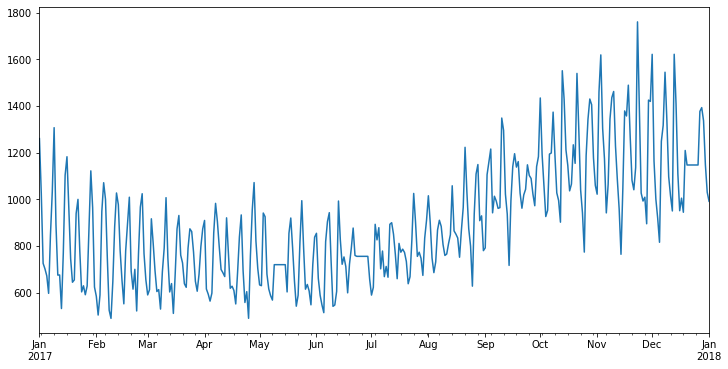

In [6]:
new_date_range = pd.date_range(start="2017-01-01", end="2018-01-01", freq="D")
df_year_17 = df_.reindex(new_date_range)
df_year_17.loc[: , target_seq_index].plot(figsize=(12,6))


<AxesSubplot:>

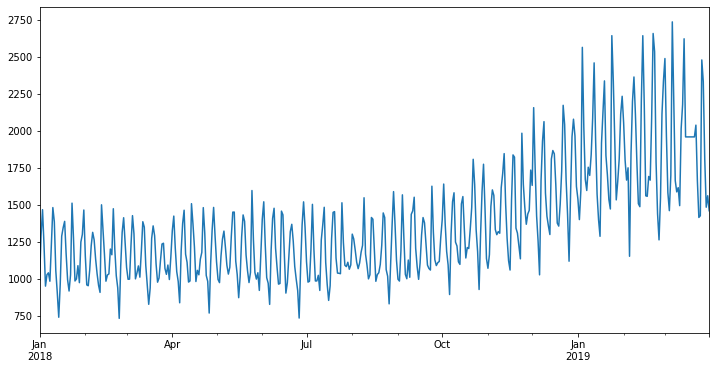

In [7]:
new_date_range = pd.date_range(start="2018-01-01", end="2019-03-31", freq="D")
df_year_17 = df_.reindex(new_date_range)
df_year_17.loc[: , target_seq_index].plot(figsize=(12,6))